In [ ]:
#| default_exp fmf_biobert

# Found My Fitness Example
>"Here we'll try using elements from the biobertApi module to label biomedical terms in the comments section of a Found My Fitness Youtube video"

In [ ]:
#|hide
from biobert_bern.biobertApi import *

Less than 5k characters. Only 1 block necessary.


In [ ]:
# !pip install pathlib

In [ ]:
import requests
import re
import pandas as pd
from nbdev.showdoc import *
import fastai
from pathlib import *
import numpy as np     
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
ls ../..

001_get_youtube_comments_fmf.ipynb
__pycache__/
biobert-bern/
found_my_fitness_UCWF8SqJVNlx-ctXbLswcTcA_48_vid_infos.csv
found_my_fitness_UCWF8SqJVNlx-ctXbLswcTcA_youtube_comments_and_vid_info_173rows.csv
found_my_fitness_UCWF8SqJVNlx-ctXbLswcTcA_youtube_comments_only_122rows.csv
found_my_fitness_UCWF8SqJVNlx-ctXbLswcTcA_youtube_comments_only_125rows.csv
youtube_api.py


In [ ]:
path = Path('../..') # save path
comment_csv= 'found_my_fitness_UCWF8SqJVNlx-ctXbLswcTcA_youtube_comments_and_vid_info_173rows.csv'
coms = pd.read_csv(path/comment_csv) #load csv
coms.rename(columns = {'comment': 'comments'},inplace=True) # rename comment to comments

## Now start splitting off all the cumsums <5000 and stack them back together.

### Create Section Labels

In [ ]:
coms.columns

Index(['vid_id', 'vid_channel_id', 'vid_deets', 'vid_response', 'title',
       'publishedAt', 'tcomment_id', 'tcresponse', 'textDisplay',
       'textOriginal', 'totalReplyCount', 'rep_comment', 'reply_id'],
      dtype='object')

In [ ]:
coms

,vid_id,vid_channel_id,vid_deets,vid_response,title,publishedAt,tcomment_id,tcresponse,textDisplay,textOriginal,totalReplyCount,rep_comment,reply_id
0,g4QqJoox8tc,UCWF8SqJVNlx-ctXbLswcTcA,"{'kind': 'youtube#videoListResponse', 'etag': ...","{'kind': 'youtube#searchResult', 'etag': 'lLPH...",Can exercise replace alcohol cravings?,2022-11-02T14:30:07Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,o4MZ-JaIvFI,UCWF8SqJVNlx-ctXbLswcTcA,"{'kind': 'youtube#videoListResponse', 'etag': ...","{'kind': 'youtube#searchResult', 'etag': 'OBRE...","George Church, PhD: Rewriting Genomes to Eradi...",2022-08-24T16:00:13Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2oT1LUeCME0,UCWF8SqJVNlx-ctXbLswcTcA,"{'kind': 'youtube#videoListResponse', 'etag': ...","{'kind': 'youtube#searchResult', 'etag': 'PLQE...",Is there a limit to human longevity?,2022-07-20T16:00:09Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,r8DSpOd0NZc,UCWF8SqJVNlx-ctXbLswcTcA,"{'kind': 'youtube#videoListResponse', 'etag': ...","{'kind': 'youtube#searchResult', 'etag': '_6XE...","Stuart Phillips, PhD, on Building Muscle with ...",2022-06-29T16:00:12Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,evQAzGaW1JU,UCWF8SqJVNlx-ctXbLswcTcA,"{'kind': 'youtube#videoListResponse', 'etag': ...","{'kind': 'youtube#searchResult', 'etag': 's6-B...",Intestinal Permeability: the Bacterial link to...,2022-05-31T15:00:13Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,g4QqJoox8tc,NaN,NaN,NaN,NaN,2022-11-02T03:21:53Z,Ugy2ZO2t370rDO-eWoZ4AaABAg,"{'kind': 'youtube#commentThread', 'etag': '4vV...",How to combat increased food intake after quit...,How to combat increased food intake after quit...,3.0,NaN,NaN
169,g4QqJoox8tc,NaN,NaN,NaN,NaN,2022-11-02T15:43:40Z,NaN,"{'kind': 'youtube#comment', 'etag': 'GB9aSyxEx...",It's brutal. Get the garbage food out of your ...,It's brutal. Get the garbage food out of your ...,NaN,"{'kind': 'youtube#comment', 'etag': 'GB9aSyxEx...",Ugy2ZO2t370rDO-eWoZ4AaABAg.9husbe2WJcN9hwCVh8KBNj
170,g4QqJoox8tc,NaN,NaN,NaN,NaN,2022-11-02T14:04:02Z,NaN,"{'kind': 'youtube#comment', 'etag': 'bs6xBMC7h...",go animal based,go animal based,NaN,"{'kind': 'youtube#comment', 'etag': 'bs6xBMC7h...",Ugy2ZO2t370rDO-eWoZ4AaABAg.9husbe2WJcN9hw15tjmPLT
171,g4QqJoox8tc,NaN,NaN,NaN,NaN,2022-11-02T11:20:13Z,NaN,"{'kind': 'youtube#comment', 'etag': 'yd5KSzb3_...",... and they said it gives you the munchies.,... and they said it gives you the munchies.,NaN,"{'kind': 'youtube#comment', 'etag': 'yd5KSzb3_...",Ugy2ZO2t370rDO-eWoZ4AaABAg.9husbe2WJcN9hvjM9rBbfr


In [ ]:
coms = create_com_with_idx(coms)

In [ ]:
coms[]

In [ ]:
coms

,idx,vid_id,vid_channel_id,vid_deets,vid_response,title,publishedAt,tcomment_id,tcresponse,textDisplay,textOriginal,totalReplyCount,rep_comment,reply_id,comments,comidx,textLen,cumTxtLen
0,0,g4QqJoox8tc,NaN,NaN,NaN,NaN,2022-11-02T04:01:53Z,UgxjeEkhSU4lZAfy5J14AaABAg,"{'kind': 'youtube#commentThread', 'etag': '5l5...",If exercise and/or the interaction with alcoho...,If exercise and/or the interaction with alcoho...,2.0,NaN,NaN,If exercise and/or the interaction with alcoho...,0:: if exercise and/or the interaction with al...,328,328
1,1,g4QqJoox8tc,NaN,NaN,NaN,NaN,2022-11-03T02:49:39Z,NaN,"{'kind': 'youtube#comment', 'etag': 'hEBHEVqvA...","Hi Rhonda, could this mean that ""one time"" phs...","Hi Rhonda, could this mean that ""one time"" phs...",NaN,"{'kind': 'youtube#comment', 'etag': 'hEBHEVqvA...",UgxjeEkhSU4lZAfy5J14AaABAg.9huxBdOoPGS9hxOiXW0kVn,"Hi Rhonda, could this mean that ""one time"" phs...","1:: hi rhonda, could this mean that ""one time""...",219,547
2,2,g4QqJoox8tc,NaN,NaN,NaN,NaN,2022-11-02T16:05:21Z,NaN,"{'kind': 'youtube#comment', 'etag': 'mbdNzSWMA...",It’s a great series! Highly suggest 💪👏💓,It’s a great series! Highly suggest 💪👏💓,NaN,"{'kind': 'youtube#comment', 'etag': 'mbdNzSWMA...",UgxjeEkhSU4lZAfy5J14AaABAg.9huxBdOoPGS9hwEzTXy2dh,It’s a great series! Highly suggest 💪👏💓,2:: it’s a great series! highly suggest 💪👏💓 ::,46,593
3,3,g4QqJoox8tc,NaN,NaN,NaN,NaN,2022-11-16T17:06:54Z,UgyEVz1JULP-TuciGs54AaABAg,"{'kind': 'youtube#commentThread', 'etag': 'kqe...","Thank you so much for researching, organizing,...","Thank you so much for researching, organizing,...",0.0,NaN,NaN,"Thank you so much for researching, organizing,...","3:: thank you so much for researching, organiz...",887,1480
4,4,g4QqJoox8tc,NaN,NaN,NaN,NaN,2022-11-16T03:37:24Z,Ugz57wD5KKrUKLvkgzJ4AaABAg,"{'kind': 'youtube#commentThread', 'etag': 'qtX...","Didn't know about this, but I'm a living anecdote","Didn't know about this, but I'm a living anecdote",0.0,NaN,NaN,"Didn't know about this, but I'm a living anecdote","4:: didn't know about this, but i'm a living a...",56,1536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,117,g4QqJoox8tc,NaN,NaN,NaN,NaN,2022-11-02T03:21:53Z,Ugy2ZO2t370rDO-eWoZ4AaABAg,"{'kind': 'youtube#commentThread', 'etag': '4vV...",How to combat increased food intake after quit...,How to combat increased food intake after quit...,3.0,NaN,NaN,How to combat increased food intake after quit...,117:: how to combat increased food intake afte...,227,24079
118,118,g4QqJoox8tc,NaN,NaN,NaN,NaN,2022-11-02T15:43:40Z,NaN,"{'kind': 'youtube#comment', 'etag': 'GB9aSyxEx...",It's brutal. Get the garbage food out of your ...,It's brutal. Get the garbage food out of your ...,NaN,"{'kind': 'youtube#comment', 'etag': 'GB9aSyxEx...",Ugy2ZO2t370rDO-eWoZ4AaABAg.9husbe2WJcN9hwCVh8KBNj,It's brutal. Get the garbage food out of your ...,118:: it's brutal. get the garbage food out of...,160,24239
119,119,g4QqJoox8tc,NaN,NaN,NaN,NaN,2022-11-02T14:04:02Z,NaN,"{'kind': 'youtube#comment', 'etag': 'bs6xBMC7h...",go animal based,go animal based,NaN,"{'kind': 'youtube#comment', 'etag': 'bs6xBMC7h...",Ugy2ZO2t370rDO-eWoZ4AaABAg.9husbe2WJcN9hw15tjmPLT,go animal based,119:: go animal based ::,24,24263
120,120,g4QqJoox8tc,NaN,NaN,NaN,NaN,2022-11-02T11:20:13Z,NaN,"{'kind': 'youtube#comment', 'etag': 'yd5KSzb3_...",... and they said it gives you the munchies.,... and they said it gives you the munchies.,NaN,"{'kind': 'youtube#comment', 'etag': 'yd5KSzb3_...",Ugy2ZO2t370rDO-eWoZ4AaABAg.9husbe2WJcN9hvjM9rBbfr,... and they said it gives you the munchies.,120:: ... and they said it gives you the munch...,53,24316


# Create Text Block
> Here we'll put all the text together

## First create a single big text_block

In [ ]:
# text_block = create_text_block(df=coms);# text_block
blocks = create_all_text_blocks(df=coms)

/Users/davidramsey/Documents/coding/youtube_scraping/foundmf/biobert-bern/biobert_bern/biobertApi.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dffk['section'] = counter
/Users/davidramsey/Documents/coding/youtube_scraping/foundmf/biobert-bern/biobert_bern/biobertApi.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cumTxtLen'] = df.textLen.cumsum()


In [ ]:
for o in blocks[:2]: print(o[:50]);print()
print('... ');print();
for o in blocks[-2:]: print(o[:50]); print()

0:: if exercise and/or the interaction with alcoho

28:: that's hilarious. my alcoholic triathlete bro

... 

77:: as a recovering alcoholic, damn sign me up fo

99:: i have to force myself, both to do exercise a



### Get Comment Spans

In [ ]:
# dfi = get_comment_spans_textblock(text_block); dfi.tail(3)

In [ ]:
# # Send it all to Bern2
# output = query_plain(text=text_block);  

## Query BERN one block at a time

In [ ]:
dfo = pd.DataFrame()
for o in blocks:
    print(len(o))
    out = query_plain(text=o)
    dfo = dfo.append({'block':o, 'out':out},ignore_index=True)
dfo.tail(2)

4811
3092
4853
3668
4865
3182


,block,out
4,"77:: as a recovering alcoholic, damn sign me u...","{'annotations': [{'id': ['mesh:D000437', 'mim:..."
5,"99:: i have to force myself, both to do exerci...","{'annotations': [{'id': ['CHEBI:16236'], 'is_n..."


# DfO = df

In [ ]:
# df = dfo
# dfo = df

In [ ]:
def merge_annotations_with_textblock_idx(dfa,#daframe containing 'span' column with the text locations of each 
                                         dfi):
    # create str_end col as type str
    dfa.span = dfa.span.astype(str)
    dfa ['str_end'] = dfa.span.str.replace(r".*'end': (\d+)}",r"\1",regex=True)
    dfa.str_end = dfa.str_end.astype(int)  # make str end as type str

    #add dfi_idx col
    dfi.reset_index(inplace=True)
    dfi.rename(columns={'index':'dfi_bloc_idx'},inplace=True)
    dfi.dfi_bloc_idx = dfi.dfi_bloc_idx.astype(int)
    # create com_idx pulling it from the text via regex
    dfi['comidx'] = dfi.text.replace(r"((\d+)?::.*)",r"\2",regex=True)
    dfi.comidx = dfi.comidx.astype(int)
    print(type(dfi.comidx[0]))
    dfi.comidx = dfi.comidx.astype(int)

    for o,m in zip(dfi.index,dfi.span):  #add dfi_idx col to dfa 
        x,y = m #open span tuple
        #write conditions for specific df rows
        conds = (dfa.str_end > x) & (dfa.str_end < y)
        dfa['dfi_bloc_idx'] = ''
        dfa.loc[conds,'dfi_bloc_idx'] = o #save the index of the dfi span that fits to dfa
        dfa.dfi_bloc_idx = dfa.dfi_bloc_idx.astype(str)
    # dfa.merge(dfi, left_on='dfi_idx',right_index=True)
    df = dfa.merge(dfi, left_on='dfi_bloc_idx',right_on='dfi_bloc_idx');
    
    return df

# Concat All Text Blocks into a nice labeled df

In [ ]:
def dfi_dfa_prep(dfa,dfi):
    '''Prepares dfi and dfa to both have dfi_bloc_idx'''
    dfi.reset_index(drop=True,inplace=True)
    dfi['dfi_bloc_idx'] = dfi.index
    # dfi.rename(columns={'index':'dfi_bloc_idx'},inplace=True)
    dfi.dfi_bloc_idx = dfi.dfi_bloc_idx.astype(int)
    # create com_idx pulling it from the text via regex
    dfi['comidx'] = dfi.text.replace(r"((\d+)?::.*)",r"\2",regex=True)
    dfi.comidx = dfi.comidx.astype(int)

    # create str_end col as type str
    dfa.span = dfa.span.astype(str)
    dfa ['str_end'] = dfa.span.str.replace(r".*'end': (\d+)}",r"\1",regex=True)
    dfa.str_end = dfa.str_end.astype(int)  # make str end as type str
    dfa['dfi_bloc_idx'] = ''
    return dfa,dfi

In [ ]:
def merge_annotations_with_dfi_bloc_idx(dfa,#daframe containing 'span' column with the text locations of each 
                                         dfi):
    '''Merges dfa with dfi so that all 'mentions' and 'obj' have a comidx(comemnt index) and a dfi_bloc_idx(dfi textbock index). This way we can track how different people have comented on each biomedical word('mention')'''
    #prep dfi and dfa
    dfa,dfi = dfi_dfa_prep(dfa,dfi)
    
    #add dfi_bloc_idx col
    for o,m in zip(dfi.index,dfi.span):  #add dfi_idx col to dfa 
        x,y = m #open span tuple
        #write conditions for specific df rows
        conds = (dfa.str_end > x) & (dfa.str_end <= y)
        dfa.loc[conds,'dfi_bloc_idx'] = o #save the index of the dfi span that fits to dfa

    dfa.dfi_bloc_idx = dfa.dfi_bloc_idx.astype(int) #make column np.64
    # merge it all

    df = dfa.merge(dfi, left_on='dfi_bloc_idx',right_on='dfi_bloc_idx')
    return df

In [ ]:
df = pd.DataFrame()
for o in dfo.index:
    dfa  =pd.DataFrame(dfo.out[o]['annotations'])
    dfi = get_comment_spans_textblock(dfo.block[o])
    dfmerg = merge_annotations_with_dfi_bloc_idx(dfa,dfi)
    df = pd.concat([df,dfmerg])

In [ ]:
def plot_bio_terms(x,y):
    # Set the width and height of the figure
    plt.figure(figsize=(8,6))
    ax = sns.barplot(x, y)

    #title
    ax.set_title(f'Biomedical Terms in Comments')
    # Add label for  axis
    ax.set(xlabel='Number of comments mentioning the term')
    plt.show()

In [ ]:
def group_bio_words(df,word_col, mention_min=2):
    dfwords = df
    dfwords = df.groupby([word_col,'obj']).id.count().reset_index().sort_values('id',ascending=False)
    dfwords = dfwords.loc[dfwords.id >=mention_min]
    dfwords.reset_index(drop=True,inplace=True)
    return dfwords

# use some regex to simplify some names

In [ ]:
df['bio_term'] = df.mention.str.replace(r'alcoholi.*',r'alcoholism',regex=True)
df['bio_term'] = df.bio_term.str.replace(r'alcohol.*disorder',r'alcoholism',regex=True)
df['bio_term'] = df.bio_term.str.replace(r'fg.*21',r'fgf21',regex=True)
df['bio_term'] = df.bio_term.str.replace('people','humans',regex=False)
df[df['bio_term'].str.contains('alcoho')].bio_term.unique()

array(['alcohol', 'alcohol craving', 'alcoholism', 'non-alcoholism'],
      dtype=object)

In [ ]:
df['bio_term'] = df.bio_term +' ('+df.obj +')'

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


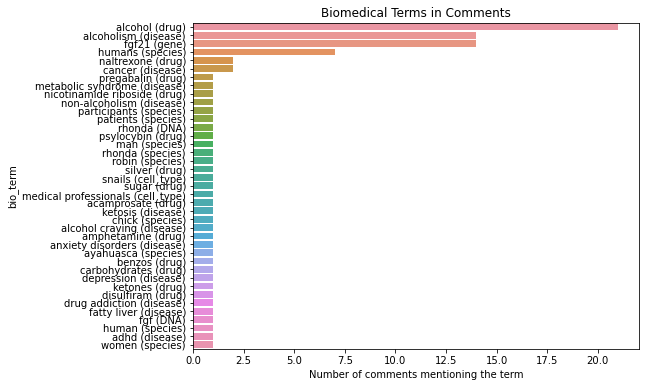

,bio_term,obj,id
0,alcohol (drug),drug,21
1,alcoholism (disease),disease,14
2,fgf21 (gene),gene,14
3,humans (species),species,7
4,naltrexone (drug),drug,2
5,cancer (disease),disease,2
6,pregabalin (drug),drug,1
7,metabolic syndrome (disease),disease,1
8,nicotinamide riboside (drug),drug,1
9,non-alcoholism (disease),disease,1


In [ ]:
#create a grouping of words mentioned
dfwords = group_bio_words(df, 'bio_term',mention_min=1)
plot_bio_terms(x=dfwords.id , y=dfwords.bio_term)
dfwords